#### Расчет скорости перемещение газовых пузырей между электродными секциями влагомера нефти.
#### Техническое задание.

![Zre.jpg](Zre.jpg)
Рисунок 1 – Электродные секции резистивного сенсора

![C97.jpg](C97.jpg)
Рисунок 2 – Электродные секции емкостного сенсора
  
Цель: Определить скорость перемещения (м/с) газовой составляющей газожидкостного потока.

#### Принцип формирования пакетов данных.
В прикрепленном архиве находятся данные, измеренные либо резистивным сенсором (Zre), либо емкостным сенсором (С). Представленные данные соответствуют шести разным потокам. Три отличных друг от друга потока (VN-29, VN-33, VN-35) были пролиты через сенсоры емкостного типа, расположенные на расстоянии 97 мм друг от друга. Так же три других отличных друг от друга потока (VN-11, VN-15, VN-17) были пролиты через сенсоры резистивного типа. Соответственно, в каждой папке содержится две папки с первичными данными для обеих секций сенсоров соответствующего типа (Lower и Upper. См. рис. 1 и рис.2). Данные для Lower и Upper секций сняты абсолютно синхронно. В каждой папке находятся первичные данные, разбитые на 10-ти секундные интервалы. Номера интервалов (ID) идут не последовательно, но в порядке возрастания, например, для Lower секции за интервалом ID#9812 следует ID#9825 и т.д. Синхронно, для Upper секции за интервалом ID#9813 следует ID#9826 и т.д. 

Колонка Stamp (время фиксации измерения) приведена в мс. Для сенсоров резистивного типа, в качестве первичных данных, использовать колонку – Zre (Ohm). Для сенсоров емкостного типа, в качестве первичных данных, использовать колонку – C (fF).

#### Задача:
1.	Для первичных данных секций емкостных сенсоров (С) удалить несущую частоту, равную, примерно, 0,3 Гц. После этой процедуры с первичными данными можно продолжать работать.  

2.	Для всех интервалов определить скорость перемещения газовой фракции методом кросскорреляции. Газовая фракция характеризуется не систематическими возмущениями измеренных первичных данных.

In [88]:
import pandas as pd
import numpy as np
from scipy.signal import correlate, correlation_lags
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as smt
import glob
from pathlib import Path
import os

In [2]:
# Импорт данных из папки VN-29 C
file_path_lower = Path('task/VN-29 C/lower')
lower = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_lower.glob('*.txt')]
file_path_upper = Path('task/VN-29 C/upper')
upper = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_upper.glob('*.txt')]

In [60]:
lower[0].head()

,Zre,Zim,T,P,C,validation
stamp,,,,,,
0.009,64449.340,-4417.5977,-241.95897,0.0,336.27610,0
1.851,63250.875,-3957.2947,-241.95897,0.0,313.00482,0
3.691,64352.195,-4689.3460,-241.95897,0.0,357.82275,0
5.530,63854.500,-4664.7280,-241.95897,0.0,361.50490,0
7.370,63824.430,-5075.4727,-241.95897,0.0,393.32110,0


In [4]:
upper[16].head()

,Zre,Zim,T,P,C,validation
stamp,,,,,,
1.085,59845.016,-1705.5685,266.4875,0.0,151.16212,32768
2.925,59801.266,-1755.6974,266.4875,0.0,155.82500,32768
4.765,59871.480,-1605.7730,266.4875,0.0,142.20480,32768
6.605,59825.598,-1570.9498,266.4875,0.0,139.33855,32768
8.445,59896.254,-1334.1711,266.4875,0.0,118.08077,32768


Для начала, удалим несущую частоту.  
Сделать это можно разными способами:  
- фактически, насколько я понимаю, это равносильно удалению сезонности. В библиотеке statsmodels есть операция seasonal_decompose удаляющая сезонность (работающая на основе преобразования Фурье);
- найти функцию синусоиды с частотой 0,3Гц, что-то вроде y(x) = k * sin(1.88x) + N, и вычесть получившиеся значения в каждом х из имеющихся значений в тех же х;
- с использованием преобразований Фурье (быстрого и обратного) и фильтра, именно этим способом и воспользуемся.

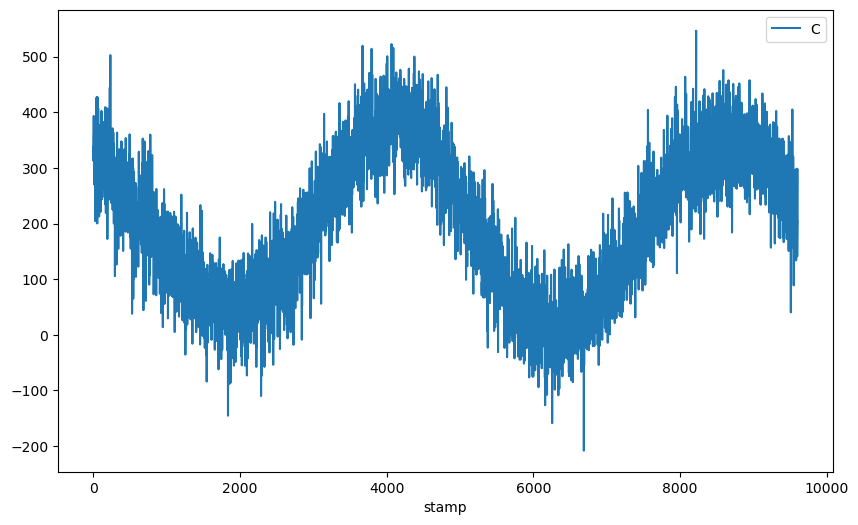

In [5]:
# Для наглядности график с первичными данными
lower[0].plot(y='C', figsize=(10,6))
plt.show()

In [6]:
# Функция для удаления несущей частоты
def removing_frequency(X):
    N = len(X)
    fft_data = np.fft.fft(X.C, n = N)
    freqs = np.fft.fftfreq(N)
    idx = np.argmax(np.abs(fft_data))
    freq = freqs[idx]
    filter_freq = 0.3
    filter = np.ones(N)
    filter[np.abs(freqs) < filter_freq] = 0
    filtered_fft_data = fft_data * filter
    filtered_data = np.real(np.fft.ifft(filtered_fft_data))
    return pd.Series(filtered_data, index = X.index)

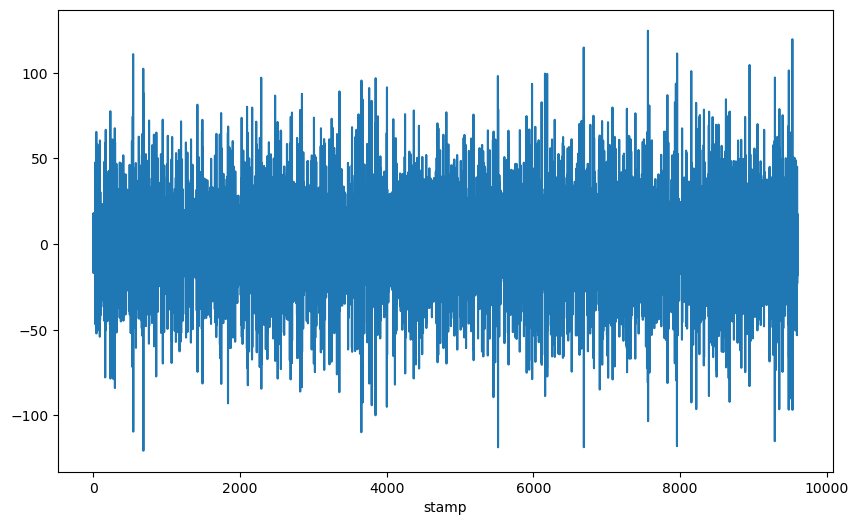

In [7]:
# График построенный на тех же данных, после удаления несущей частоты
removing_frequency(lower[0]).plot(figsize=(10, 6))
plt.show()

Определить скорость перемещения газовой фракции методом кросскорреляции, также можно различными методами и библиотека:
- scipy.signal correlate;
- numpy.correlate;
- statsmodels.ccf/ccovf;
- xcorr в matlab;
- алгоритм Dynamic-time warping, но, его, как будто бы, лучше применять в распознавании речи, однако, и в этом случае, я думаю можно.

In [170]:
#statsmodels.ccf
ccf29C0 = smt.ccf(removing_frequency(lower[0]), removing_frequency(upper[0]), adjusted=False)
time_delay = lower[0].iloc[np.argmax(ccf29C0)]
print('Время прохождения потока от нижнего сенсора до верхнего:', time_delay.name, 'мс')

Время прохождения потока от нижнего сенсора до верхнего: 947.547 мс


In [172]:
distance_between_sensors = 97
velocity = distance_between_sensors / time_delay.name
print('Скорость перемещения газовой фракции составила', round(velocity, 5), 'мм/мс (м/с) или', round(velocity, 5)*100, 'см/с')

Скорость перемещения газовой фракции составила 0.10237 мм/мс (м/с) или 10.237 см/с


In [224]:
#statsmodels.ccovf
ccovf29C0 = smt.ccovf(removing_frequency(lower[0]), removing_frequency(upper[0]), adjusted=False)
time_delay = lower[0].iloc[np.argmax(ccovf29C0)]
velocity = distance_between_sensors / time_delay.name
print('Скорость перемещения газовой фракции составила', round(velocity, 5), 'мм/мс (м/с)')

Скорость перемещения газовой фракции составила 0.10237 мм/мс (м/с)


ccf и ccovf дали один и тот же результат, что не удивительно, однако scipy.signal correlate и numpy.correlate дают другие результаты:

In [183]:
#scipy correlate
cross_correlation = correlate(removing_frequency(lower[0]), removing_frequency(upper[0]), mode = 'full')
lags = correlation_lags(removing_frequency(lower[0]).size, removing_frequency(upper[0]).size, mode="full")
lag = lags[np.argmax(correlation)]
lag

-33

Выходит, что максимальное значение кросс-корреляции достигается при отрицательной скорости, то есть течения потока от верхнего сенсора к нижнему, что противоречит условиям задачи.

In [184]:
time_delay = upper[0].iloc[abs(lags[np.argmax(correlation)])]
time_delay.name

60.728

In [186]:
distance_between_sensors = 97
velocity = distance_between_sensors / time_delay.name
print('Скорость перемещения газовой фракции составила', round(velocity, 5), 'мм/мс (м/с), но в обратную сторону')

Скорость перемещения газовой фракции составила 1.59729 мм/мс (м/с), но в обратную сторону


Так как, у нас четко закреплено, что поток идет от нижнего сенсора к верхнему, то данный вариант исключаем, однако, необходимо разобраться.  
Функция statsmodels ccf производит расчет лага только вперед, но если поменять ряды местами, или произвести расчет в обе стороны, то получается тот же результат:

In [211]:
backwards = smt.ccf(removing_frequency(upper[0]), removing_frequency(lower[0]), adjusted=False)[::-1]
forwards = smt.ccf(removing_frequency(lower[0]), removing_frequency(upper[0]), adjusted=False)
ccf_output = np.r_[backwards[:-1], forwards]

In [212]:
lags = correlation_lags(removing_frequency(lower[0]).size, removing_frequency(upper[0]).size, mode="full")
lag = lags[np.argmax(ccf_output)]
lag

-33

Если посмотреть несколько максимальных значений кросс-корреляции в обоих направлениях и сравнить с максимальным значением кросс-корреляции с расчетом лага только вперед, можно заметить повторяющуюся цифру 0.07462649846041931, это и есть полученные выше 0.10237 мм/мс

In [218]:
from heapq import nlargest

res = nlargest(4, ccf_output)
res

[0.08148154141982351,
 0.07462649846041931,
 0.07084309621907359,
 0.06956879695339725]

In [215]:
ccf29C0 = smt.ccf(removing_frequency(lower[0]), removing_frequency(upper[0]), adjusted=False)
max(ccf29C0)

0.07462649846041931

Выходит, при данных условиях, вычисление кросс-корреляции с помощью statsmodels.ccf/ccovf достаточно.

In [227]:
print('Скорость перемещения газовой фракции в интервале id=16252-id=16250 VN-29 C составила', round(velocity, 5), 'мм/мс (м/с)')

Скорость перемещения газовой фракции в интервале id=16252-id=16250 VN-29 C составила 0.10237 мм/мс (м/с)


##### Судя по тексту задачи, следует, что в одной папке находятся данные одного испытания, разбитые на 10-ти секундные интервалы, поэтому логично было бы объеденить txt файлы в папке lower в один датафрейм и проводить кросс-корреляцию с таким же объединенным датафреймом из папки upper.
##### Однако, в задаче четко прописано определить скорость для всех интервалов.

In [574]:
#Функция расчета скорости
def velocity(i):
    ccovf = smt.ccovf(removing_frequency(lower[i]), removing_frequency(upper[i]), adjusted=False)
    time_delay = lower[i].iloc[np.argmax(ccovf)]
    velocity = distance_between_sensors / time_delay.name
    return velocity

In [560]:
#Создание датафрейма для занесения данных
VN29C = pd.DataFrame(list(zip(os.listdir('task/VN-29 C/lower'), os.listdir('task/VN-29 C/upper'))), 
                      columns = ['lower file', 'upper file'])
vel = []
for i in range(len(VN29C)):
    vel.append(velocity(i))
VN29C["velocity"] = vel

#### Полученная скорость перемещения газовой фракции для каждой пары интервалов в папке VN-29 C

In [561]:
VN29C

,lower file,upper file,velocity
0,id=16252_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16250_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.102370
1,id=16265_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16263_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.018412
2,id=16278_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16276_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.090446
3,id=16291_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16289_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.051155
4,id=16304_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16302_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.080259
5,id=16317_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16315_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.166637
6,id=16331_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16329_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.472084
7,id=16344_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16342_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.053160
8,id=16357_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16355_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.352010
9,id=16370_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,id=16368_W=3.70_GVF=40.60_GFR=12.91_LFR=2.61.txt,0.629531


#### Cкорость перемещения газовой фракции для каждой пары интервалов в папке VN-33 C

In [575]:
file_path_lower = Path('task/VN-33 C/lower')
lower = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_lower.glob('*.txt')]
file_path_upper = Path('task/VN-33 C/upper')
upper = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_upper.glob('*.txt')]

In [576]:
VN33C = pd.DataFrame(list(zip(os.listdir('task/VN-33 C/lower'), os.listdir('task/VN-33 C/upper'))), 
                      columns = ['lower file', 'upper file'])
vel1 = []
for i in range(len(VN33C)):
    vel1.append(velocity(i))
VN33C["velocity"] = vel1

In [577]:
VN33C

,lower file,upper file,velocity
0,id=16787_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16785_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,0.266260
1,id=16801_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16799_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,0.100047
2,id=16814_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16812_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,0.101814
3,id=16827_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16825_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,0.104067
4,id=16840_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16838_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,0.040452
5,id=16853_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16851_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,0.426586
6,id=16866_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16864_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,0.616746
7,id=16879_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16877_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,0.072504
8,id=16892_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16890_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,0.045053
9,id=16905_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,id=16903_W=4.60_GVF=65.40_GFR=224.60_LFR=14.14...,13.016640


#### Cкорость перемещения газовой фракции для каждой пары интервалов в папке VN-35 C

In [583]:
file_path_lower = Path('task/VN-35 C/lower')
lower = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_lower.glob('*.txt')]
file_path_upper = Path('task/VN-35 C/upper')
upper = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_upper.glob('*.txt')]

In [579]:
VN35C = pd.DataFrame(list(zip(os.listdir('task/VN-35 C/lower'), os.listdir('task/VN-35 C/upper'))), 
                      columns = ['lower file', 'upper file'])
vel1 = []
for i in range(len(VN35C)):
    vel1.append(velocity(i))
VN35C["velocity"] = vel1

In [580]:
VN35C

,lower file,upper file,velocity
0,id=18173_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18171_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.093311
1,id=18187_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18185_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.062971
2,id=18200_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18198_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.096595
3,id=18214_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18212_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.112998
4,id=18227_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18225_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.191825
5,id=18240_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18238_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.058681
6,id=18253_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18251_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.025594
7,id=18266_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18264_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.043000
8,id=18278_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18276_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.076449
9,id=18290_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,id=18288_W=40.70_GVF=0.00_GFR=118.00_LFR=20.77...,0.075798


#### Cкорость перемещения газовой фракции для каждой пары интервалов в папке VN-11 Zre

In [616]:
file_path_lower = Path('task/VN-11 Zre/lower')
lower = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_lower.glob('*.txt')]
file_path_upper = Path('task/VN-11 Zre/upper')
upper = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_upper.glob('*.txt')]

In [634]:
# Функция для вычисления скорости без поправки на несущую частоту
distance_between_sensors = 60
def velocity(i):
    ccf = smt.ccf(lower[i]['Zre'], upper[i]['Zre'], adjusted=False)
    time_delay = lower[i].iloc[np.argmax(ccf)]  
    velocity = distance_between_sensors / time_delay.name
    return velocity

In [632]:
VN11Zre = pd.DataFrame(list(zip(os.listdir('task/VN-11 Zre/lower'), os.listdir('task/VN-11 Zre/upper'))), 
                      columns = ['lower file', 'upper file'])
vel = []
for i in range(len(VN11Zre)):
    vel.append(velocity(i))
VN11Zre["velocity"] = vel

In [633]:
VN11Zre

,lower file,upper file,velocity
0,id=10006_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=10007_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,0.030176
1,id=10018_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=10019_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,0.022486
2,id=10030_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=10031_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,0.034410
3,id=10042_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=10043_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,0.045008
4,id=9812_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=9813_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,0.017879
5,id=9825_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=9826_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,22.246941
6,id=9838_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=9839_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,0.092981
7,id=9851_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=9852_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,0.049582
8,id=9864_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=9865_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,0.129465
9,id=9877_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,id=9878_W=55.50_GVF=37.40_GFR=8.65_LFR=2.61.txt,0.017461


#### Cкорость перемещения газовой фракции для каждой пары интервалов в папке VN-15 Zre

In [635]:
file_path_lower = Path('task/VN-15 Zre/lower')
lower = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_lower.glob('*.txt')]
file_path_upper = Path('task/VN-15 Zre/upper')
upper = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_upper.glob('*.txt')]

In [636]:
VN15Zre = pd.DataFrame(list(zip(os.listdir('task/VN-15 Zre/lower'), os.listdir('task/VN-15 Zre/upper'))), 
                      columns = ['lower file', 'upper file'])
vel = []
for i in range(len(VN15Zre)):
    vel.append(velocity(i))
VN15Zre["velocity"] = vel

In [637]:
VN15Zre

,lower file,upper file,velocity
0,id=10483_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10484_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,1.175157
1,id=10497_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10498_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,0.982495
2,id=10510_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10511_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,1.255703
3,id=10523_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10524_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,0.859193
4,id=10536_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10537_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,1.194315
5,id=10549_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10550_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,1.039285
6,id=10562_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10563_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,0.928663
7,id=10575_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10576_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,1.273642
8,id=10588_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10589_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,0.835701
9,id=10601_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,id=10602_W=52.70_GVF=65.70_GFR=224.07_LFR=15.1...,1.044841


#### Cкорость перемещения газовой фракции для каждой пары интервалов в папке VN-17 Zre

In [638]:
file_path_lower = Path('task/VN-17 Zre/lower')
lower = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_lower.glob('*.txt')]
file_path_upper = Path('task/VN-17 Zre/upper')
upper = [pd.read_table(f, index_col=False).set_index('stamp') for f in file_path_upper.glob('*.txt')]

In [639]:
VN17Zre = pd.DataFrame(list(zip(os.listdir('task/VN-17 Zre/lower'), os.listdir('task/VN-17 Zre/upper'))), 
                      columns = ['lower file', 'upper file'])
vel = []
for i in range(len(VN17Zre)):
    vel.append(velocity(i))
VN17Zre["velocity"] = vel

In [640]:
VN17Zre

,lower file,upper file,velocity
0,id=12367_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12368_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,1.057735
1,id=12380_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12381_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,2.103344
2,id=12393_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12394_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,0.871916
3,id=12406_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12407_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,0.887036
4,id=12420_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12421_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,1.048823
5,id=12433_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12434_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,1.152538
6,id=12446_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12447_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,1.331292
7,id=12459_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12460_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,0.875171
8,id=12472_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12473_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,1.191800
9,id=12485_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,id=12486_W=52.00_GVF=41.00_GFR=117.80_LFR=21.9...,0.884643
